In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Imports and Setup</h2>
</div>

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from collections import Counter
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## <span style="color:transparent;">Load and Explore Dataset</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Load and Explore Dataset</h2>
</div>

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
# Display and check the column structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Dataset contains 5,572 entries with the following columns:

* v1: The label indicating whether the message is 'ham' (legitimate) or 'spam'.
* v2: The raw text of the SMS message.
* Unnamed: 2, Unnamed: 3, and Unnamed: 4: These columns contain mostly NaN values, with very few populated rows. They appear to be unnecessary for our task.

## <span style="color:transparent;">Data Cleaning</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Data Cleaning</h2>
</div>

In [6]:
# Drop the unnecessary columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
# Clean the dataset by dropping unnecessary columns and renaming relevant ones
df = df[['v1', 'v2']]  
df.columns = ['label', 'message']  # Rename columns for clarity

In [8]:
# Display the first few rows of the dataset
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The unnecessary columns have been successfully dropped, and the dataset now contains only two columns:

* label: Indicates if the message is "ham" or "spam".
* message: Contains the text of the SMS message.

In [9]:
# Verify if there are any missing values in the cleaned data
missing_data = df.isnull().sum()

# Display the count of missing values
missing_data

label      0
message    0
dtype: int64

In [10]:
# Check for duplicate entries in the dataset
duplicates = df.duplicated().sum()

# Display the count of duplicate entries
duplicates


403

In [11]:
df[df.duplicated(keep='first')].head()

,label,message
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls


* Since duplicate messages exist, it's essential to decide how to manage them. Typically, we remove duplicates to ensure the dataset only contains unique records. 

In [12]:
# Remove duplicate entries, keeping only the first occurrence
df = df.drop_duplicates(keep='first')

# Confirm the new shape after removing duplicates
df.shape, df.head()


((5169, 2),
   label                                            message
 0   ham  Go until jurong point, crazy.. Available only ...
 1   ham                      Ok lar... Joking wif u oni...
 2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
 3   ham  U dun say so early hor... U c already then say...
 4   ham  Nah I don't think he goes to usf, he lives aro...)

In [13]:
df.duplicated().sum()

0

## <span style="color:transparent;">Feature Engineering</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Feature Engineering</h2>
</div>

In [14]:
# Feature 1: Length of the message (character count)
df['message_length'] = df['message'].apply(len)
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
# Feature 2: Word count in each message
df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df.head()

,label,message,message_length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


In [16]:
# Feature 3: Sentence count (using period '.' as separator)
df['sentence_count'] = df['message'].apply(lambda x: len(re.split(r'[.!?]+', x)) - 1)
df.head()

,label,message,message_length,word_count,sentence_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3
1,ham,Ok lar... Joking wif u oni...,29,6,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1
3,ham,U dun say so early hor... U c already then say...,49,11,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0


In [17]:
# Feature 4: Count of numbers in the message
df['number_count'] = df['message'].apply(lambda x: len(re.findall(r'\d+', x)))
df.head()

,label,message,message_length,word_count,sentence_count,number_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1,6
3,ham,U dun say so early hor... U c already then say...,49,11,2,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0


In [18]:
# Feature 5: Count of special characters in the message
special_chars = string.punctuation
df['special_count'] = df['message'].apply(lambda x: sum(1 for char in x if char in special_chars))
df.head()

,label,message,message_length,word_count,sentence_count,number_count,special_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,0,9
1,ham,Ok lar... Joking wif u oni...,29,6,2,0,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1,6,6
3,ham,U dun say so early hor... U c already then say...,49,11,2,0,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,2


In [19]:
# Feature 6: Punctuation count
df['punctuation_count'] = df['message'].apply(lambda x: sum(1 for char in x if char in '.!?'))
df.head()

,label,message,message_length,word_count,sentence_count,number_count,special_count,punctuation_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,0,9,8
1,ham,Ok lar... Joking wif u oni...,29,6,2,0,6,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1,6,6,1
3,ham,U dun say so early hor... U c already then say...,49,11,2,0,6,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,2,0


In [20]:
# Feature 7: Count of capitalized words
df['capitalized_count'] = df['message'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
df.head()

,label,message,message_length,word_count,sentence_count,number_count,special_count,punctuation_count,capitalized_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,3,0,9,8,0
1,ham,Ok lar... Joking wif u oni...,29,6,2,0,6,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1,6,6,1,2
3,ham,U dun say so early hor... U c already then say...,49,11,2,0,6,6,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,2,0,1


The feature engineering process is complete. A summary of the new features added to the dataset:

1. **message_length**: The total number of characters in the message.
2. **word_count**: The total number of words in the message.
3. **sentence_count**: The number of sentences (separated by periods, exclamations, or question marks).
4. **number_count**: The count of numeric values in the message.
5. **special_count**: The count of special characters (e.g., `@, #, $`).
6. **punctuation_count**: The count of punctuation marks (`.`, `!`, `?`).
7. **capitalized_count**: The number of fully capitalized words in the message.



In [21]:
# After feature engineering display and check the column structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              5169 non-null   object
 1   message            5169 non-null   object
 2   message_length     5169 non-null   int64 
 3   word_count         5169 non-null   int64 
 4   sentence_count     5169 non-null   int64 
 5   number_count       5169 non-null   int64 
 6   special_count      5169 non-null   int64 
 7   punctuation_count  5169 non-null   int64 
 8   capitalized_count  5169 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 403.8+ KB


## <span style="color:transparent;">Exploratory Data Analysis (EDA)</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Exploratory Data Analysis (EDA)</h2>
</div>

In [22]:
# View basic statistics of all features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
message_length,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
word_count,5169.0,15.340685,11.068488,1.0,7.0,12.0,22.0,171.0
sentence_count,5169.0,1.846779,1.745441,0.0,1.0,2.0,3.0,39.0
number_count,5169.0,0.759915,1.801866,0.0,0.0,0.0,1.0,14.0
special_count,5169.0,4.091120,4.444055,0.0,2.0,3.0,6.0,133.0
punctuation_count,5169.0,2.461018,2.686481,0.0,1.0,2.0,3.0,42.0
capitalized_count,5169.0,1.041594,2.750670,0.0,0.0,0.0,1.0,37.0


In [23]:
# Calculate message length statistics for ham and spam
ham_stats = df[df['label'] == 'ham']['message_length'].describe()
spam_stats = df[df['label'] == 'spam']['message_length'].describe()

print("Ham Message Length Stats:\n", ham_stats)
print("\nSpam Message Length Stats:\n", spam_stats)

Ham Message Length Stats:
 count    4516.000000
mean       70.459256
std        56.358207
min         2.000000
25%        34.000000
50%        52.000000
75%        90.000000
max       910.000000
Name: message_length, dtype: float64

Spam Message Length Stats:
 count    653.000000
mean     137.891271
std       30.137753
min       13.000000
25%      132.000000
50%      149.000000
75%      157.000000
max      224.000000
Name: message_length, dtype: float64


**Observations:**

* Most ham messages are relatively short, with half of them being 52 characters or fewer.
* A few outliers (e.g., max length of 910) indicate occasional long messages (e.g., detailed conversations or special notifications).
* Spam messages tend to be longer than ham messages, with a mean of 138 characters.
* Most spam messages are clustered between 132 and 157 characters, which aligns with promotional or marketing content requiring more space.
* Maximum length of 224 characters suggests that spam messages are concise but packed with offers, promotions, or links.

**Key Insights:**
Spam messages are generally longer than ham messages, with almost double the mean length.
Ham messages have higher variance in length (as shown by the larger standard deviation), while spam messages are more consistently sized (mean ≈ 138).
Length-based filtering: Message length can be a useful feature to distinguish between ham and spam, as spam messages tend to be longer.

In [24]:
# Calculate message word count statistics for ham and spam
ham_stats = df[df['label'] == 'ham']['word_count'].describe()
spam_stats = df[df['label'] == 'spam']['word_count'].describe()

print("Ham Message Word Count Stats:\n", ham_stats)
print("\nSpam Message Word Count Stats:\n", spam_stats)

Ham Message Word Count Stats:
 count    4516.000000
mean       14.134632
std        11.116240
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       171.000000
Name: word_count, dtype: float64

Spam Message Word Count Stats:
 count    653.000000
mean      23.681470
std        5.967672
min        2.000000
25%       22.000000
50%       25.000000
75%       28.000000
max       35.000000
Name: word_count, dtype: float64


**Observations:**

* Ham messages show high variability in word count, ranging from 1 to 171 words.
* Many ham messages are short and concise, with half of them containing 11 words or fewer.
* Some longer ham messages (like notifications or discussions) drive the higher standard deviation.
* Spam messages are longer on average, with a mean of 24 words, almost double that of ham messages.
* Most spam messages are consistently around 22-28 words, showing less variability compared to ham.
* The max word count of 35 reflects a typical upper limit, aligning with the promotional nature of these messages.

**Key Insights**
Spam messages tend to have more words than ham messages, with a median of 25 words compared to 11 for ham messages.
Ham messages show more variability (with some extremely long messages), whereas spam messages are consistently longer but less variable.


In [25]:
# Calculate message sentence count statistics for ham and spam
ham_stats = df[df['label'] == 'ham']['sentence_count'].describe()
spam_stats = df[df['label'] == 'spam']['sentence_count'].describe()

print("Ham Message Sentence Count Stats:\n", ham_stats)
print("\nSpam Message Sentence Count Stats:\n", spam_stats)

Ham Message Sentence Count Stats:
 count    4516.000000
mean        1.692648
std         1.681598
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        39.000000
Name: sentence_count, dtype: float64

Spam Message Sentence Count Stats:
 count    653.000000
mean       2.912711
std        1.806610
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: sentence_count, dtype: float64


**Observations:**

* Ham messages are typically short, with half of the messages containing only 1 sentence.
* A few longer messages (up to 39 sentences) cause the larger standard deviation, suggesting that conversations or notifications can vary widely in length.
* 25% of ham messages have only 1 sentence, showing their concise nature.
* Spam messages generally contain more sentences, with a median of 3 sentences.
* There is less variability in spam messages (max of 9 sentences) compared to ham, reflecting the structured nature of promotional content.
* Many spam messages are 2 to 4 sentences long, likely including offers, instructions, and calls to action.

**Key Insights**
Spam messages tend to contain more sentences than ham messages, with a median of 3 sentences vs. 1 sentence for ham.
Ham messages show greater variability in sentence count, with some outliers containing up to 39 sentences.

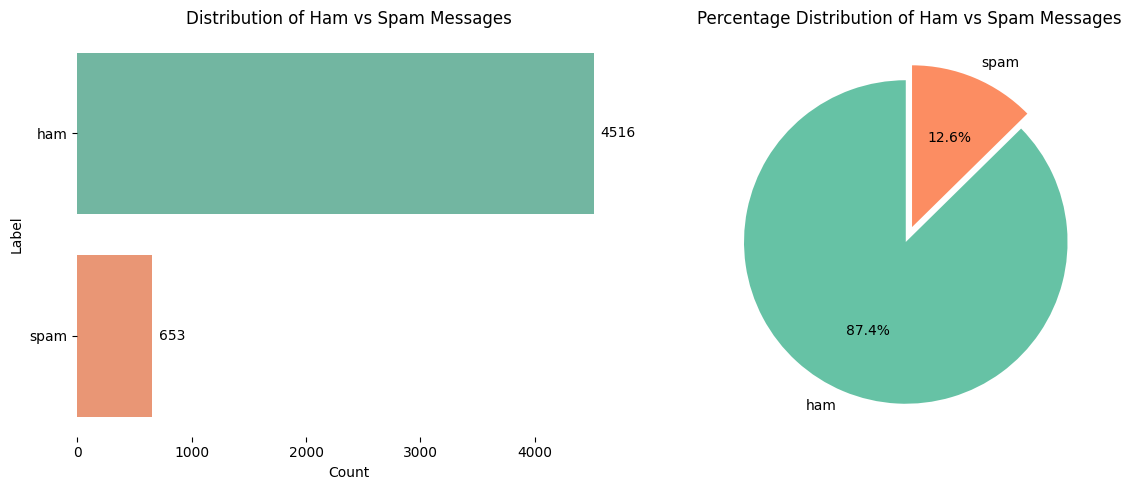

In [26]:
# Create side-by-side plots for the distribution of 'ham' vs 'spam' messages

plt.figure(figsize=(12, 5))

# Bar Plot: Distribution of Ham vs Spam Messages
plt.subplot(1, 2, 1)
sns.countplot(y='label', data=df, palette='Set2')
plt.title('Distribution of Ham vs Spam Messages')
plt.xlabel('Count')
plt.ylabel('Label')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Pie Chart: Percentage Distribution of Ham vs Spam Messages
plt.subplot(1, 2, 2)
df['label'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    colors=sns.color_palette('Set2'), 
    startangle=90, 
    explode=[0.05] * df['label'].nunique()
)
plt.title('Percentage Distribution of Ham vs Spam Messages')
plt.ylabel('')  

plt.tight_layout()
plt.show()

The distribution of ham vs spam messages:

* Clearly shows the imbalance between ham (legitimate) and spam messages.
* There are 4,516 ham messages and 653 spam messages.
* Displays the percentage distribution:
    - Ham: 87.4%
    - Spam: 12.6%

These visualizations confirm that the dataset is imbalanced, which is important to consider when building a predictive model.

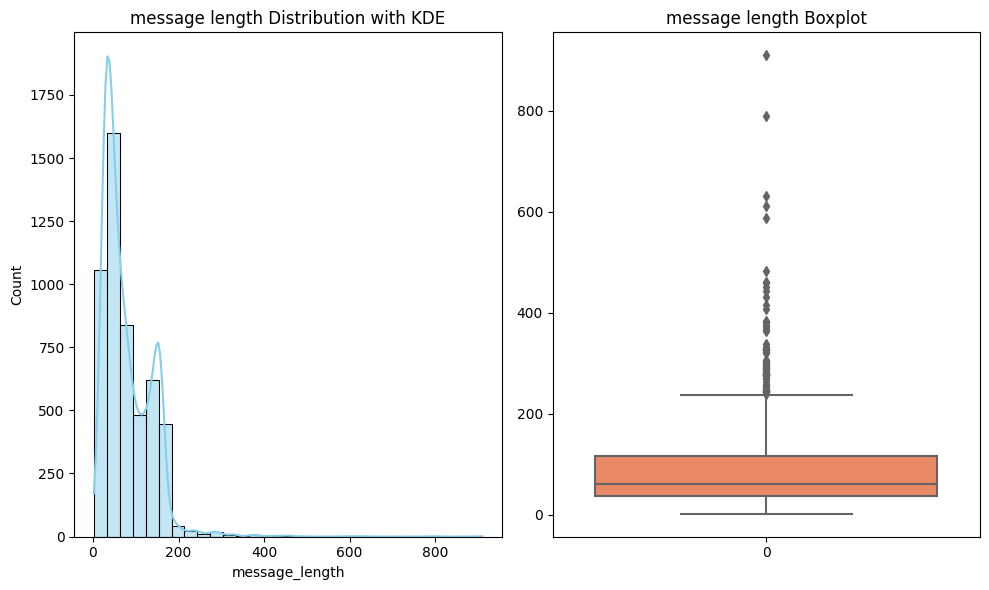


Summary Statistics for message length:
 count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: message_length, dtype: float64


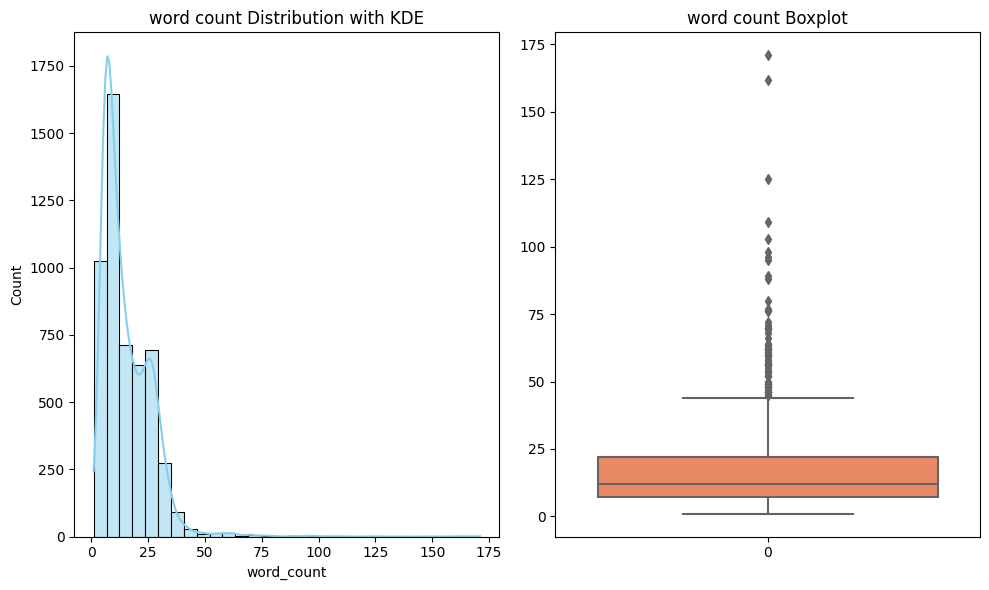


Summary Statistics for word count:
 count    5169.000000
mean       15.340685
std        11.068488
min         1.000000
25%         7.000000
50%        12.000000
75%        22.000000
max       171.000000
Name: word_count, dtype: float64


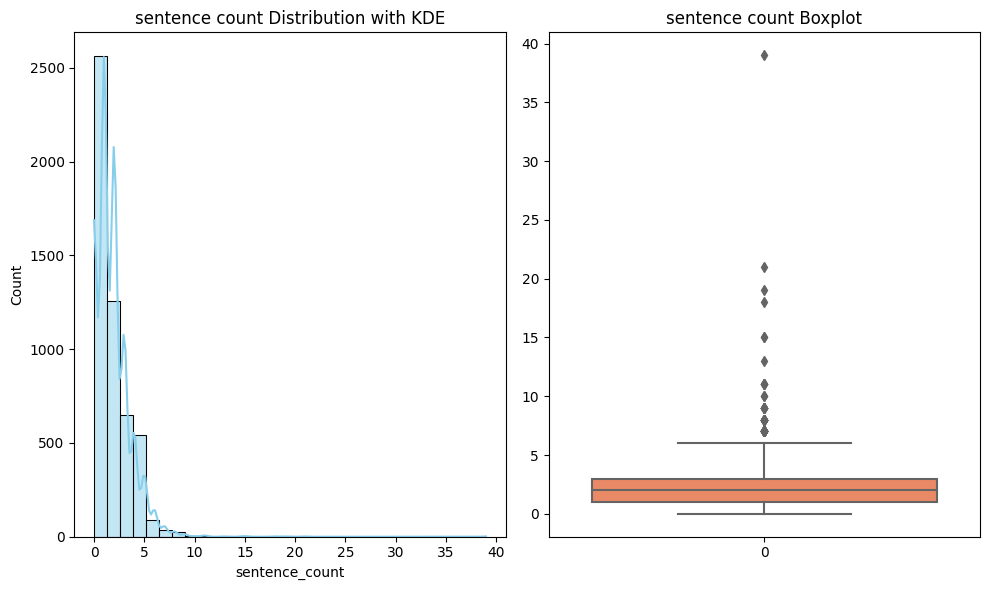


Summary Statistics for sentence count:
 count    5169.000000
mean        1.846779
std         1.745441
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        39.000000
Name: sentence_count, dtype: float64


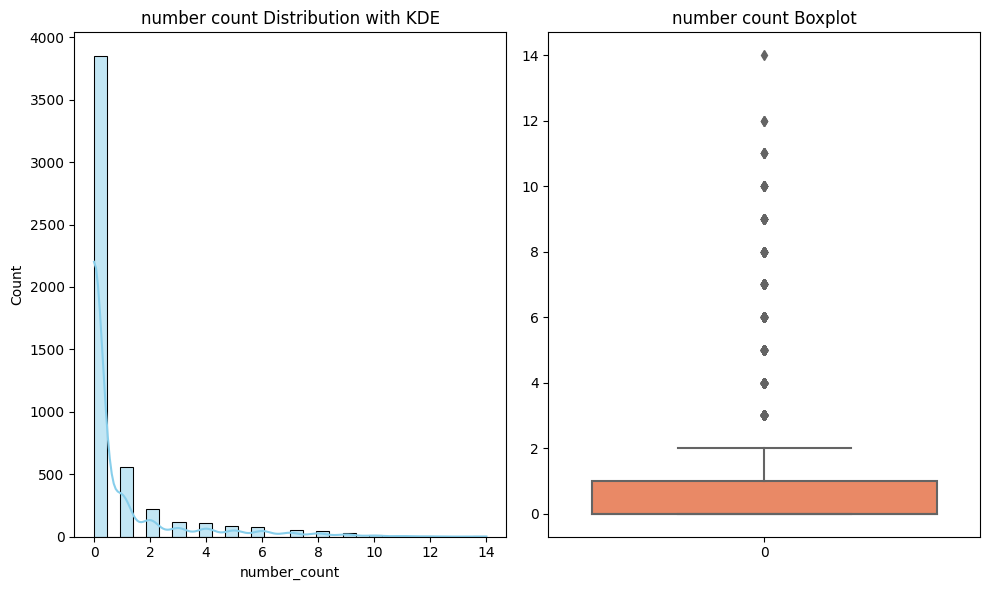


Summary Statistics for number count:
 count    5169.000000
mean        0.759915
std         1.801866
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        14.000000
Name: number_count, dtype: float64


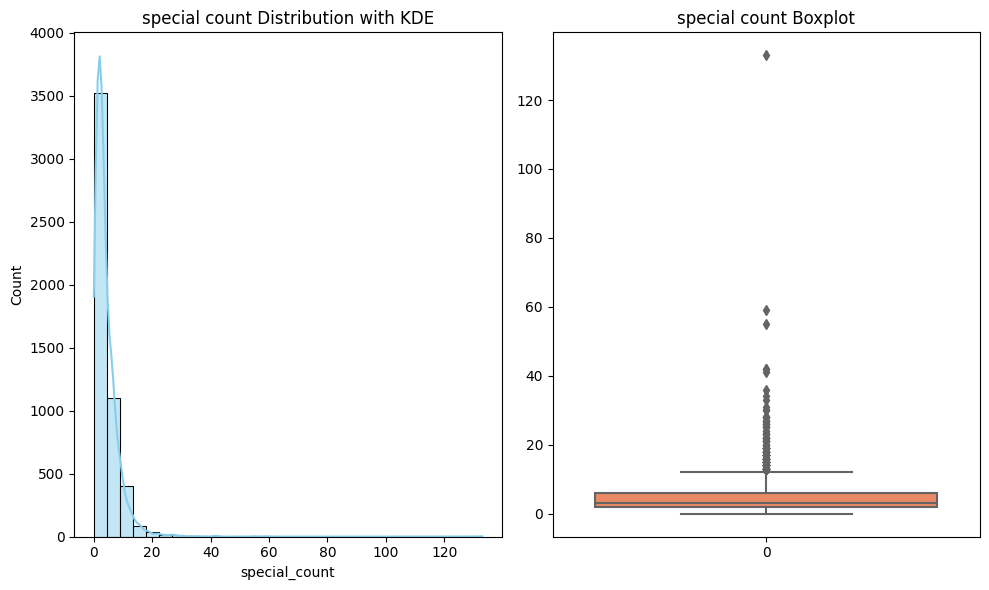


Summary Statistics for special count:
 count    5169.000000
mean        4.091120
std         4.444055
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       133.000000
Name: special_count, dtype: float64


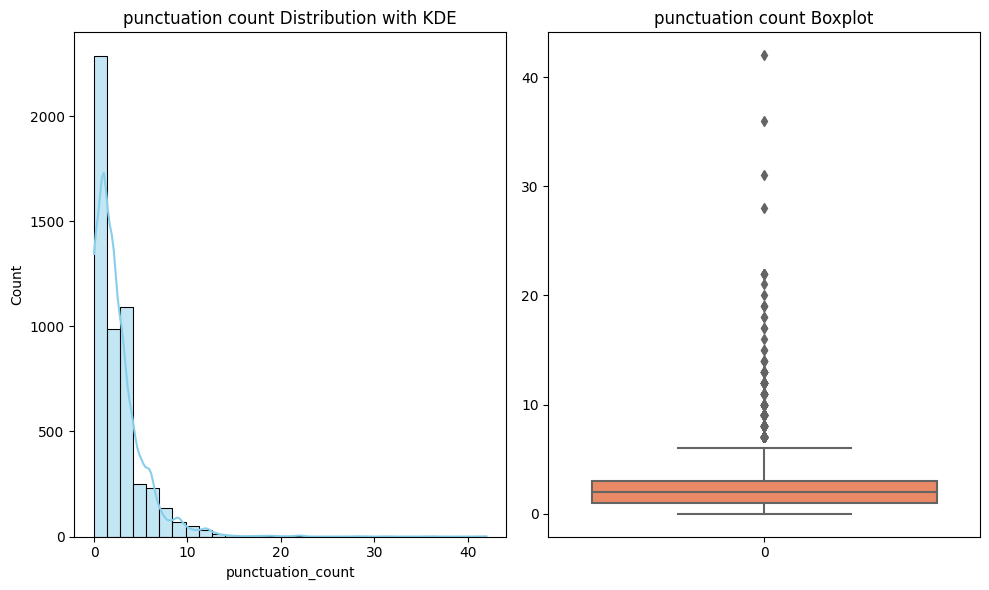


Summary Statistics for punctuation count:
 count    5169.000000
mean        2.461018
std         2.686481
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        42.000000
Name: punctuation_count, dtype: float64


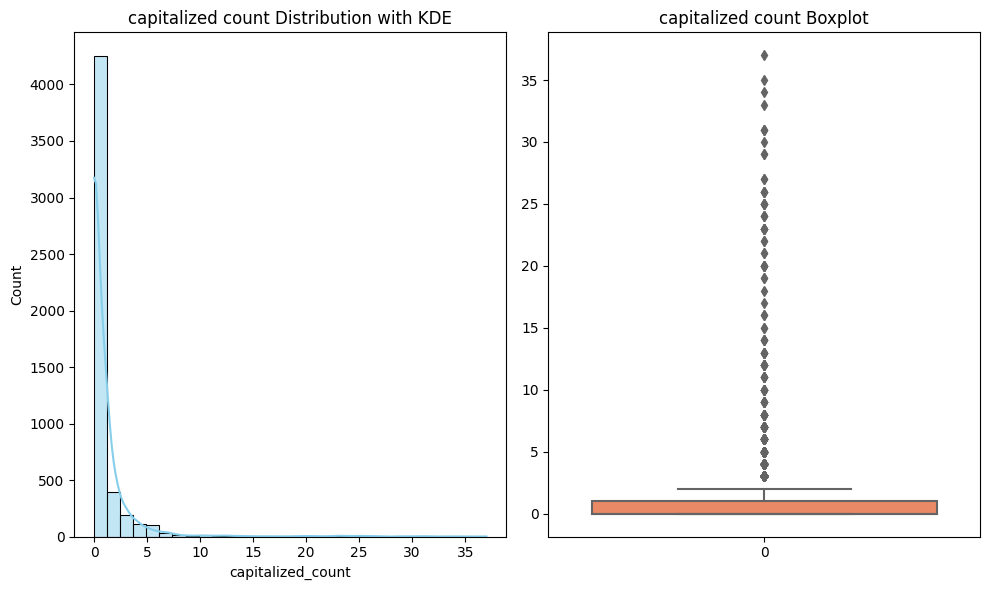


Summary Statistics for capitalized count:
 count    5169.000000
mean        1.041594
std         2.750670
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        37.000000
Name: capitalized_count, dtype: float64


In [27]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, bins=30, color='skyblue')
    plt.title(f'{title} Distribution with KDE')

    plt.subplot(1, 2, 2)
    sns.boxplot(data[column], color='coral')
    plt.title(f'{title} Boxplot')

    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

columns_to_analyze = ['message_length', 'word_count', 'sentence_count', 'number_count', 'special_count', 'punctuation_count', 'capitalized_count']

for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

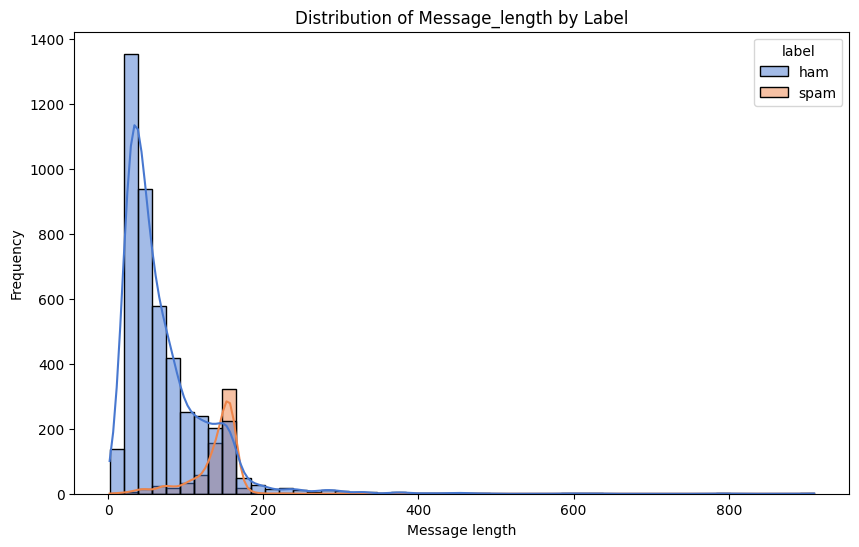

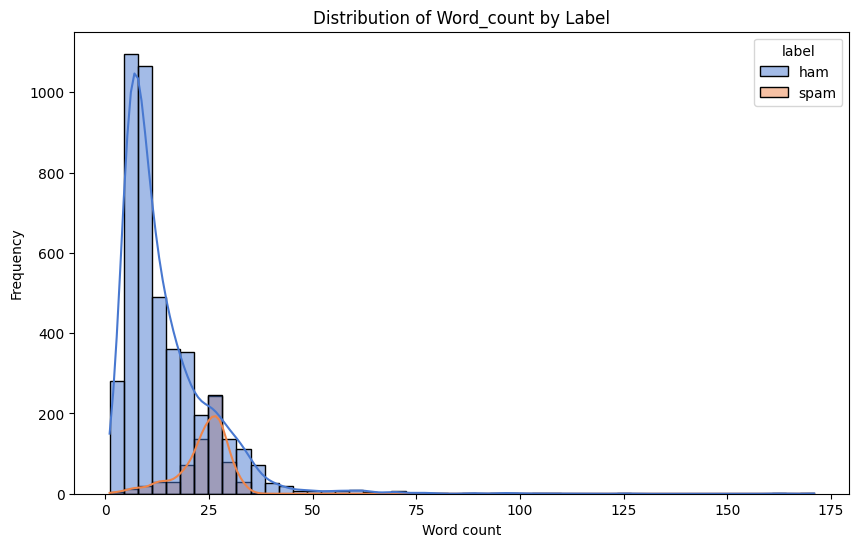

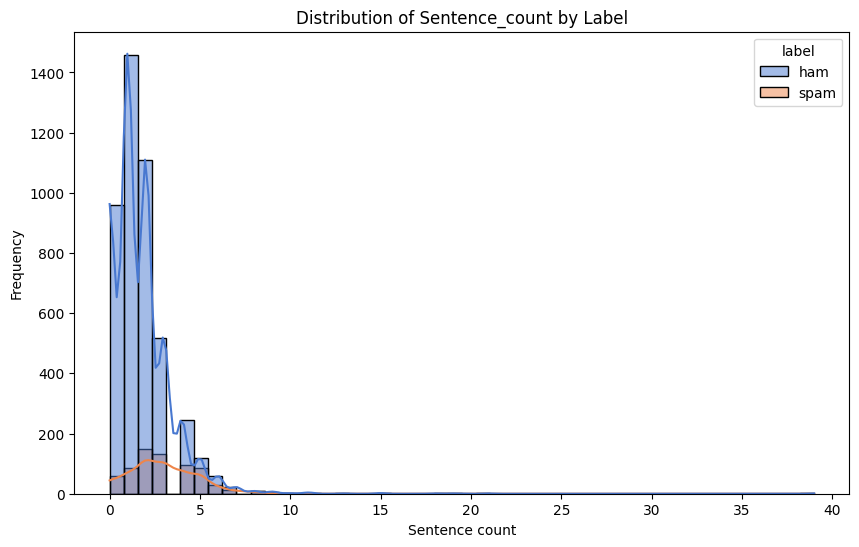

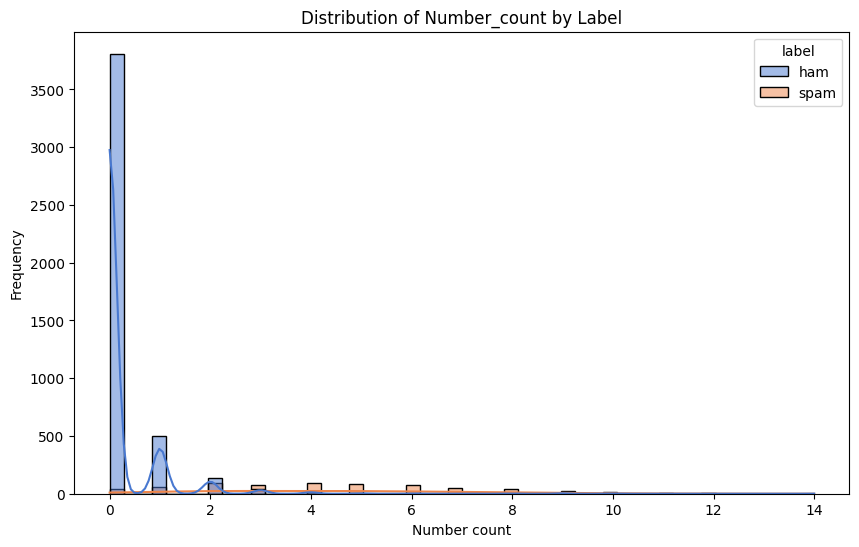

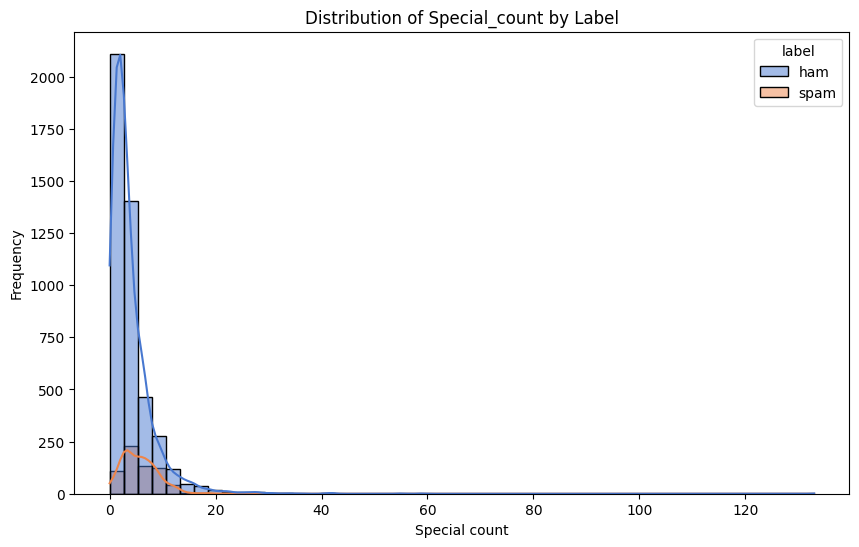

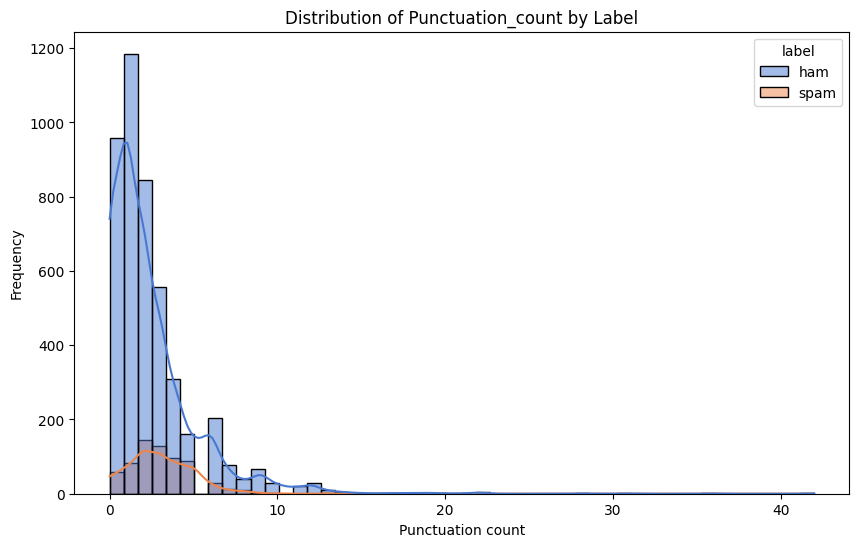

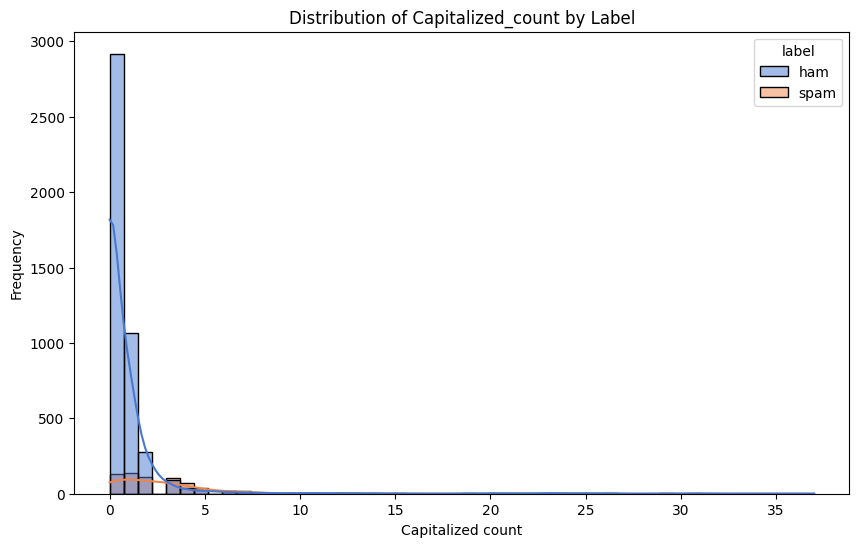

In [28]:
# Function to visualize the distribution of a feature for 'ham' and 'spam' messages
def plot_feature_distribution(data, feature, bins=50):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='label', bins=bins, kde=True, palette='muted')
    plt.title(f'Distribution of {feature.capitalize()} by Label')
    plt.xlabel(feature.capitalize().replace('_', ' '))
    plt.ylabel('Frequency')
    plt.show()

# Visualize the distribution of features
plot_feature_distribution(df, 'message_length')
plot_feature_distribution(df, 'word_count')
plot_feature_distribution(df, 'sentence_count')
plot_feature_distribution(df, 'number_count')
plot_feature_distribution(df, 'special_count')
plot_feature_distribution(df, 'punctuation_count')
plot_feature_distribution(df, 'capitalized_count')


In [29]:
# Average Feature Counts: Ham vs Spam Messages
avg_counts = df.groupby('label')[['message_length', 'word_count', 'sentence_count', 'number_count', 'special_count', 'punctuation_count', 'capitalized_count']].mean()
avg_counts

,message_length,word_count,sentence_count,number_count,special_count,punctuation_count,capitalized_count
label,,,,,,,
ham,70.459256,14.134632,1.692648,0.242914,3.865810,2.384190,0.824181
spam,137.891271,23.681470,2.912711,4.335375,5.649311,2.992343,2.545176


**Key Insights**

1. **Message Length**:
   - **Spam messages** are on average **twice as long** as ham messages (138 vs. 70 characters).
   - Longer message length is a **strong indicator of spam**.

2. **Word Count**:
   - Spam messages have a **higher word count** (24 words on average) compared to ham messages (14 words).
   - This aligns with the promotional or informational nature of spam.

3. **Sentence Count**:
   - Spam messages contain **more sentences** (2.91 vs. 1.69), suggesting that they use a structured approach to convey information (e.g., intro + offer + call to action).

4. **Number Count**:
   - **Spam messages** use significantly more numbers (4.34 on average) compared to ham messages (0.24).
   - Numbers in spam messages are often used for **phone numbers, promo codes, or prices**.

5. **Special Character Count**:
   - Spam messages have **more special characters** (5.65 vs. 3.87), likely to attract attention or provide **URLs** or **hashtags**.

6. **Punctuation Count**:
   - Spam messages use slightly more punctuation marks (2.99 vs. 2.38), often for emphasis (`!`, `?`).

7. **Capitalized Word Count**:
   - Spam messages contain **more capitalized words** (2.55 vs. 0.82), indicating the use of **emphasized words** (e.g., "WIN", "FREE") to attract attention.

In [30]:
# Tokenize and extract the most common words
def get_top_words(messages, n=20):
    words = ' '.join(messages).split()
    return Counter(words).most_common(n)

ham_words = get_top_words(df[df['label'] == 'ham']['message'])
spam_words = get_top_words(df[df['label'] == 'spam']['message'])

print("Top 20 Words in Ham Messages:", ham_words)
print("Top 20 Words in Spam Messages:", spam_words)


Top 20 Words in Ham Messages: [('to', 1450), ('you', 1412), ('I', 1349), ('the', 954), ('a', 884), ('i', 714), ('and', 712), ('in', 677), ('u', 576), ('my', 570), ('is', 561), ('me', 513), ('for', 452), ('of', 452), ('that', 387), ('it', 357), ('your', 346), ('have', 337), ('on', 334), ('at', 316)]
Top 20 Words in Spam Messages: [('to', 522), ('a', 314), ('your', 171), ('call', 163), ('the', 160), ('or', 155), ('for', 152), ('2', 151), ('you', 150), ('is', 130), ('Call', 116), ('on', 112), ('have', 110), ('from', 109), ('and', 102), ('&', 89), ('with', 86), ('ur', 86), ('of', 79), ('FREE', 75)]


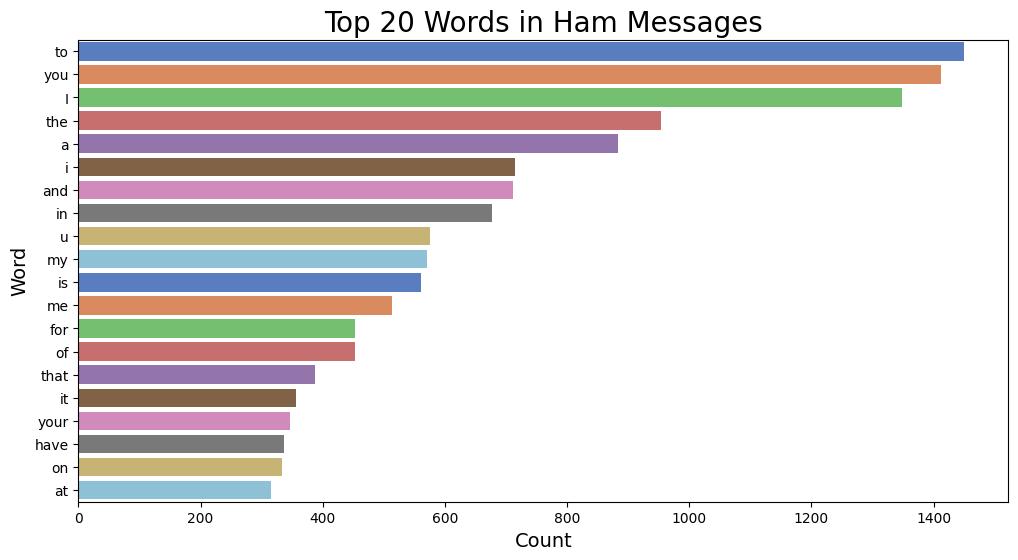

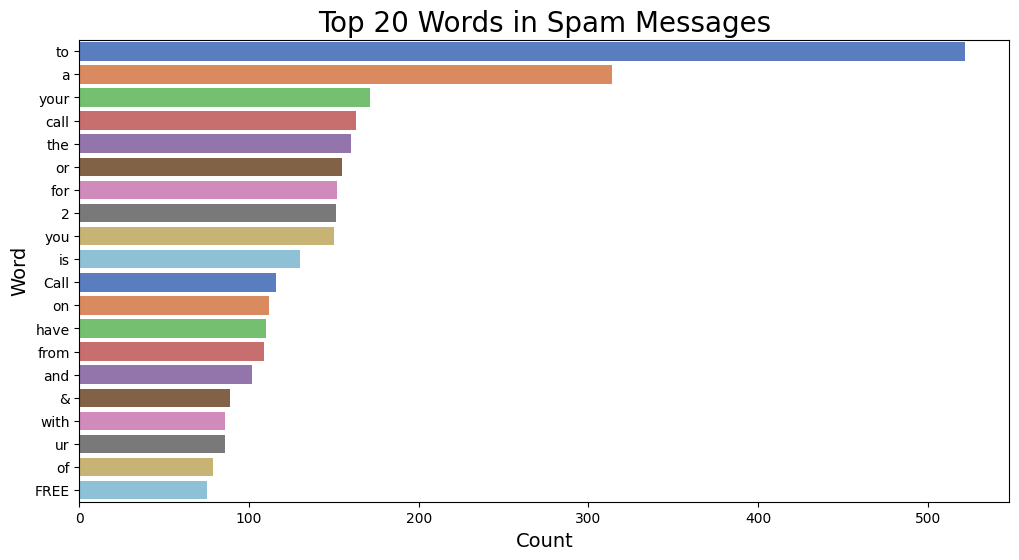

In [31]:
# Convert the top words into DataFrames for visualization
ham_words_df = pd.DataFrame(ham_words, columns=['word', 'count'])
spam_words_df = pd.DataFrame(spam_words, columns=['word', 'count'])

# Function to plot the top words
def plot_top_words(words_df, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=words_df, x='count', y='word', palette='muted')
    plt.title(title, fontsize=20)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Word', fontsize=14)
    plt.show()

plot_top_words(ham_words_df, "Top 20 Words in Ham Messages")
plot_top_words(spam_words_df, "Top 20 Words in Spam Messages")

Key Insights

* Spam messages are more likely to contain numbers and marketing terms such as "call", "FREE", and "&", which suggests promotional content.
* Ham messages tend to contain common conversational words like "I", "you", "my", and "u", indicating a focus on personal communication

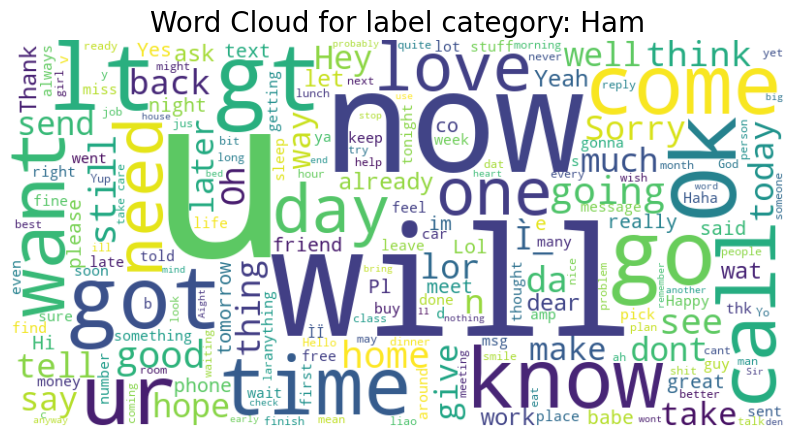

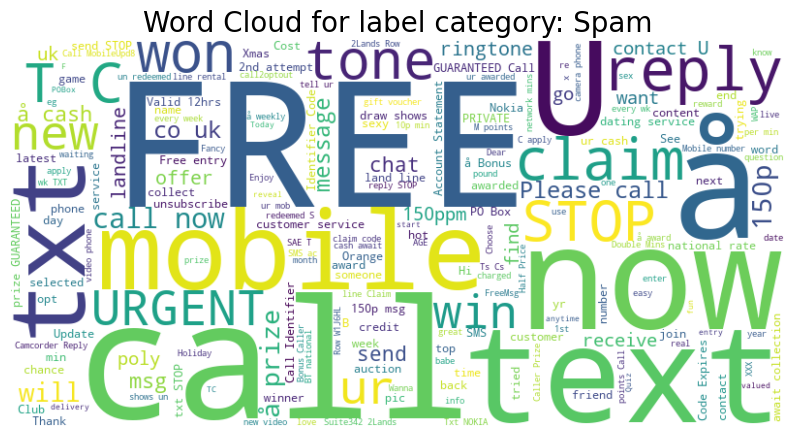

In [32]:
# Function to generate and display word clouds for message by category
def generate_wordcloud_for_category(data, category, title):
    # Filter messages based on the category (ham or spam)
    category_data = data[data['label'] == category]['message']
    
    # Create a word cloud for the selected category
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(category_data))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.title(f"{title}: {category.capitalize()}", fontsize=20)
    plt.show()

generate_wordcloud_for_category(df, 'ham', "Word Cloud for label category")
generate_wordcloud_for_category(df, 'spam', "Word Cloud for label category")


## <span style="color:transparent;">Label Encoding</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Label Encoding</h2>
</div>

In [33]:
# Initialize the encoder
encoder = LabelEncoder()

# Encode the 'label' column
df['label_encoded'] = encoder.fit_transform(df['label'])

# Verify the encoding
print(df[['label', 'label_encoded']].head())

  label  label_encoded
0   ham              0
1   ham              0
2  spam              1
3   ham              0
4   ham              0


For binary classification problems like this, Label Encoding is simple and effective. It assigns:

* 'ham' → 0
* 'spam' → 1

This encoding is suitable because the labels are binary, and the numeric values (0 or 1) directly map to two distinct classes.

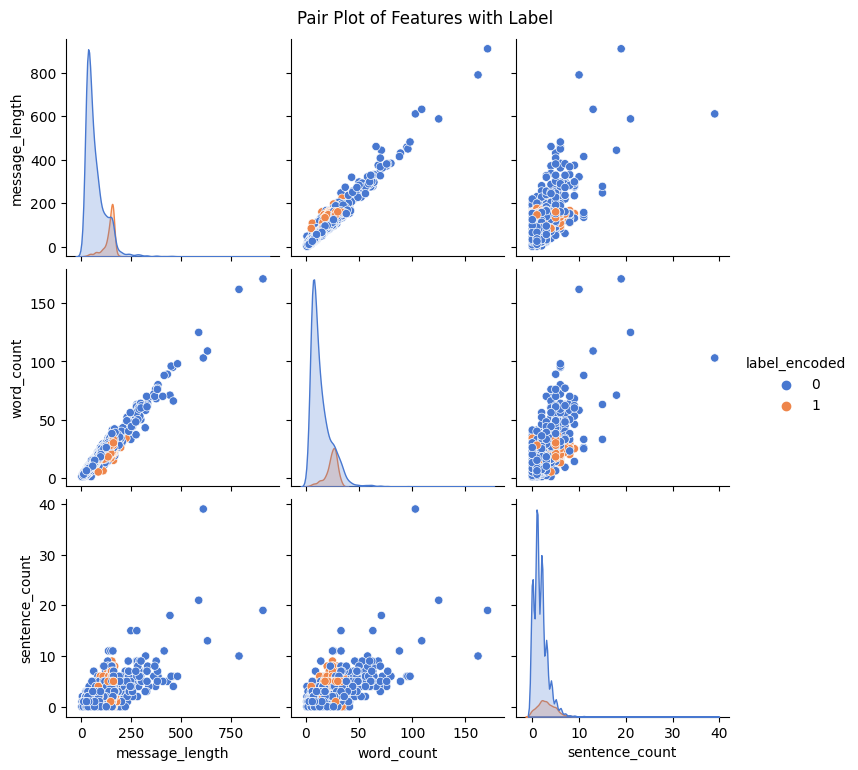

In [34]:
# Prepare the data for the pair plot
features_for_pairplot = df[['message_length', 'word_count', 'sentence_count', 'label_encoded']]

# Create a pair plot to visualize the relationships between features and label
sns.pairplot(data=features_for_pairplot, hue='label_encoded', palette='muted', diag_kind='kde')
plt.suptitle('Pair Plot of Features with Label', y=1.02)  
plt.show()


Interpretation:

* Spam messages tend to have higher values for message length, word count, and sentence count.
* There is a noticeable separation between spam and ham messages, particularly when considering message length and word count.

This plot highlights that message length, word count, and sentence count are useful features to distinguish between ham and spam messages, making them valuable for building a classifier.

In [35]:
# Select the relevant features
features_for_heatmap = df[
    ['message_length', 'word_count', 'sentence_count', 
     'number_count', 'special_count', 'punctuation_count', 
     'capitalized_count', 'label_encoded']
]

# Calculate the correlation matrix
correlation_matrix = features_for_heatmap.corr()
correlation_matrix


,message_length,word_count,sentence_count,number_count,special_count,punctuation_count,capitalized_count,label_encoded
message_length,1.000000,0.973667,0.642615,0.418816,0.615089,0.491426,0.256848,0.384717
word_count,0.973667,1.000000,0.615637,0.338030,0.567402,0.473288,0.263072,0.286576
sentence_count,0.642615,0.615637,1.000000,0.313644,0.728214,0.819334,0.177289,0.232245
number_count,0.418816,0.338030,0.313644,1.000000,0.247034,0.164935,0.271630,0.754625
special_count,0.615089,0.567402,0.728214,0.247034,1.000000,0.786706,0.135093,0.133341
punctuation_count,0.491426,0.473288,0.819334,0.164935,0.786706,1.000000,0.120658,0.075214
capitalized_count,0.256848,0.263072,0.177289,0.271630,0.135093,0.120658,1.000000,0.207879
label_encoded,0.384717,0.286576,0.232245,0.754625,0.133341,0.075214,0.207879,1.000000


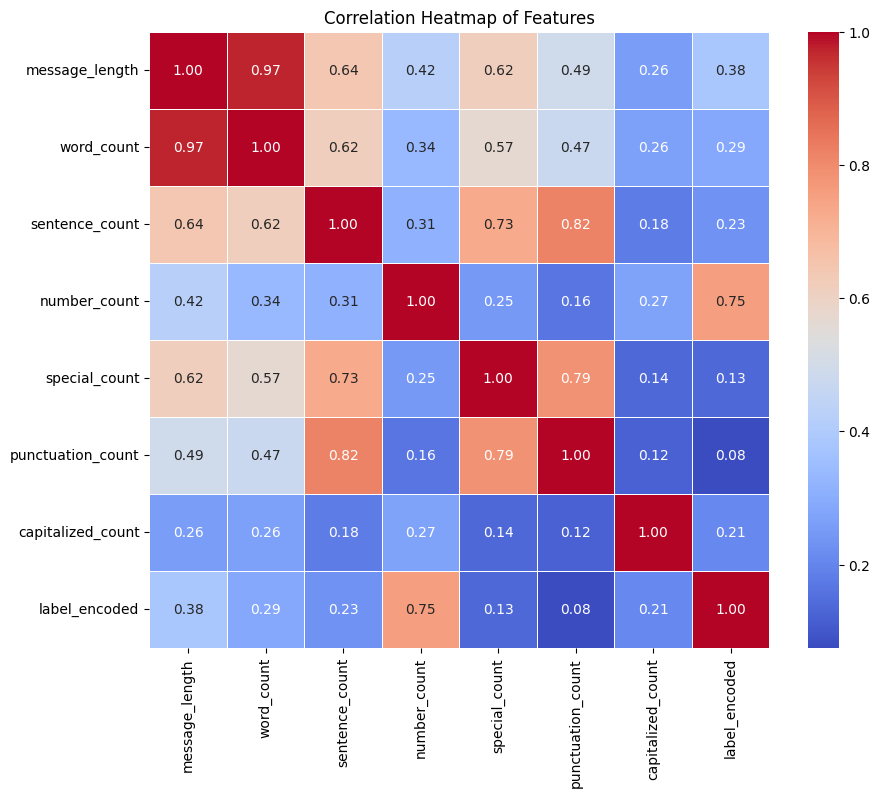

In [36]:
# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

The correlations between the features and with the `label_encoded` column (0 = ham, 1 = spam).

**Observations**

1. **Correlation with `label_encoded` (Spam vs Ham)**
   - **number_count**: **0.75** — Strongest positive correlation with spam messages. Spam messages often contain numbers (e.g., promo codes, phone numbers).
   - **message_length**: **0.38** — Moderate correlation with spam messages. Spam messages tend to be longer.
   - **word_count**: **0.29** — Weak but positive correlation. Spam messages often contain more words.
   - **capitalized_count**: **0.21** — Weak positive correlation. Spam messages use more capitalized words (e.g., "FREE", "WIN").
   - **punctuation_count**: **0.07** — Very weak correlation, indicating that punctuation alone isn't a strong indicator of spam.

2. **Feature Relationships (Between Features)**
   - **message_length & word_count**: **0.97** — Very strong positive correlation, as longer messages naturally contain more words.
   - **special_count & sentence_count**: **0.73** — High correlation, as messages with more sentences tend to use more special characters (e.g., punctuation).
   - **sentence_count & punctuation_count**: **0.82** — Strong correlation, as longer messages with multiple sentences have more punctuation.

3. **`number_count`**
   - **High correlation with label_encoded (0.75)** — Suggests that messages containing numbers are a good predictor of spam.
   - **Moderate correlation with message_length (0.41)** — Indicates that longer messages are more likely to contain numbers.


## <span style="color:transparent;">Text Preprocessing</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Text Preprocessing</h2>
</div>

In [37]:
# Initialize stopwords and the stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess and transform text
def transform_text(text):
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Tokenize the text into words
    tokens = word_tokenize(text)
    
    # 3. Remove special characters and punctuation
    tokens = [word for word in tokens if word.isalnum()]
    
    # 4. Remove stopwords and short words (optional, length <= 2)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 5. Apply stemming to reduce words to their root form
    transformed_tokens = [stemmer.stem(word) for word in tokens]
    
    # Join the tokens back into a single string
    return " ".join(transformed_tokens)

# Apply the transformation to the 'message' column
df['transformed_text'] = df['message'].apply(transform_text)

Explanation of the Steps:

1. Lowercase Conversion: Ensures uniformity by converting all text to lowercase.
2. Tokenization: Splits the message into individual words (tokens).
3. Removing Special Characters and Punctuation: Only keeps alphanumeric words.
4. Removing Stopwords: Filters out common English stopwords (e.g., "the", "is").
5. Stemming: Reduces words to their root form (e.g., "running" → "run").


In [38]:
# Display the first few rows to verify the transformation
df[['message', 'transformed_text']].head()

,message,transformed_text
0,"Go until jurong point, crazy.. Available only ...",jurong point avail bugi great world buffet cin...
1,Ok lar... Joking wif u oni...,lar joke wif oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win cup final tkt 21st ma...
3,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


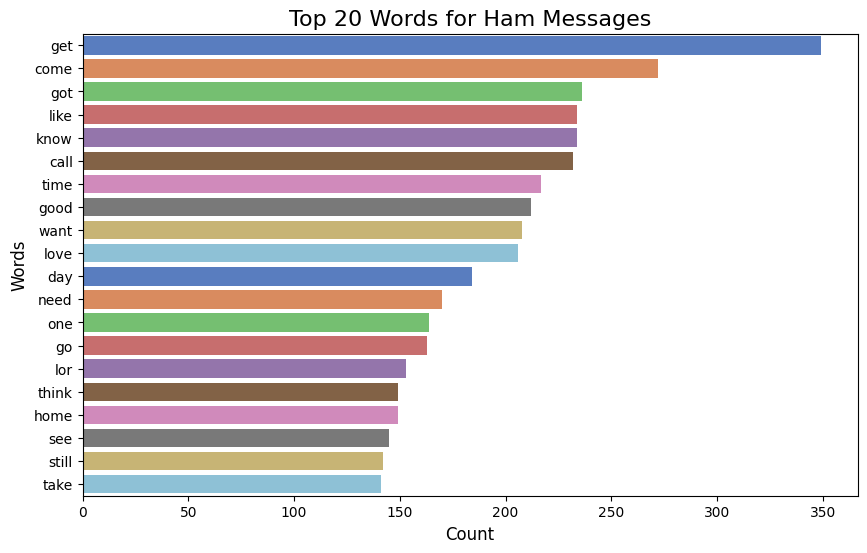

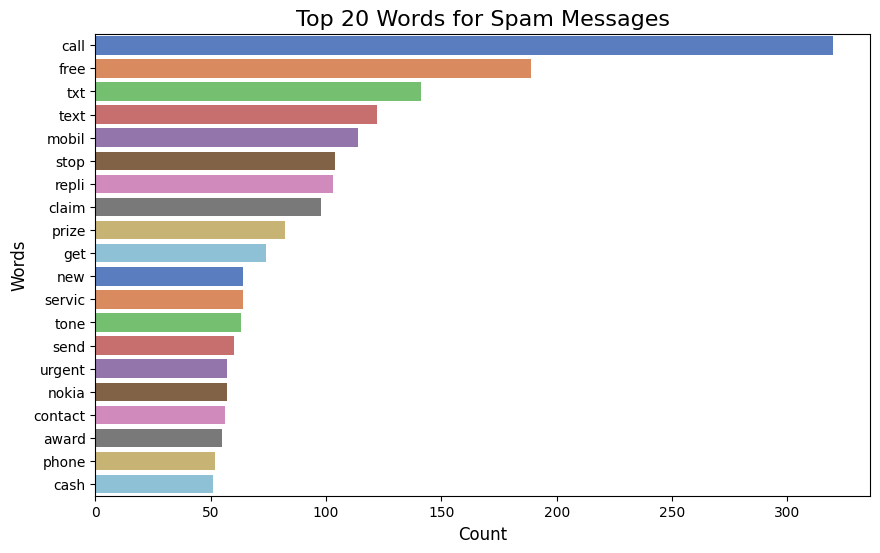

In [39]:
# Function to plot the top N words for a specific label
def plot_top_words(data, label, top_n=20):
    # Filter messages by label and extract transformed text
    label_data = data[data['label'] == label]['transformed_text']
    
    # Flatten all words from all messages and count their frequency
    all_words = " ".join(label_data).split()
    word_counts = Counter(all_words).most_common(top_n)
    
    words, counts = zip(*word_counts)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette='muted')
    plt.title(f'Top {top_n} Words for {label.capitalize()} Messages', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.show()

plot_top_words(df, 'ham', top_n=20)

plot_top_words(df, 'spam', top_n=20)


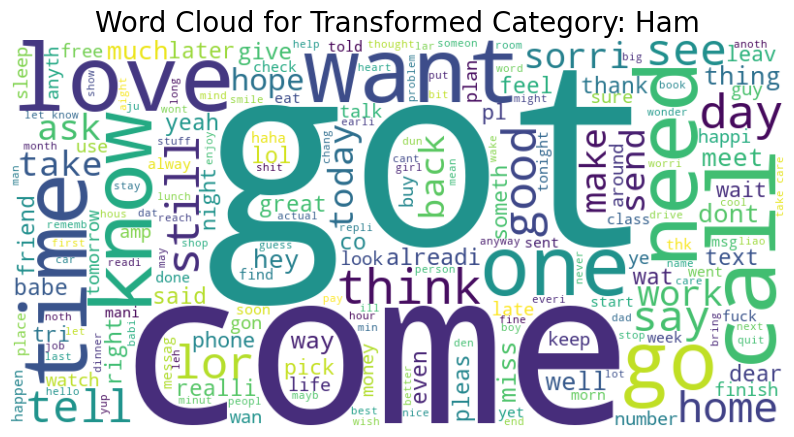

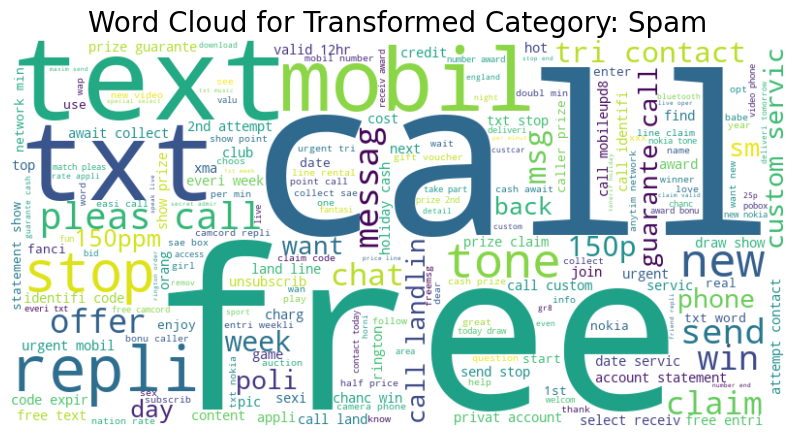

In [40]:
# Function to generate and display word clouds for transformed text by category
def generate_wordcloud_for_transformed_category(data, category, title):
    # Filter transformed texts based on the category (ham or spam)
    category_data = data[data['label'] == category]['transformed_text']
    
    # Create a word cloud for the selected category
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(category_data))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.title(f"{title}: {category.capitalize()}", fontsize=20)
    plt.show()

generate_wordcloud_for_transformed_category(df, 'ham', "Word Cloud for Transformed Category")
generate_wordcloud_for_transformed_category(df, 'spam', "Word Cloud for Transformed Category")


* Ham Messages: Common, non-promotional words likely remain, such as conversational terms.
* Spam Messages: Words like "call", "free", "text", etc., might dominate after preprocessing.

## <span style="color:transparent;">Modeling</span>

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h2 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">Modeling</h2>
</div>

In [41]:
# Split the data into features (X) and target (y)
X = df['transformed_text']
y = df['label_encoded']  # 0 = ham, 1 = spam

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [42]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)  # Limit to top 3000 features

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [43]:
# Initialize the models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": LinearSVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}



Naive Bayes - Model Evaluation:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1331
           1       0.98      0.75      0.85       220

    accuracy                           0.96      1551
   macro avg       0.97      0.87      0.91      1551
weighted avg       0.96      0.96      0.96      1551



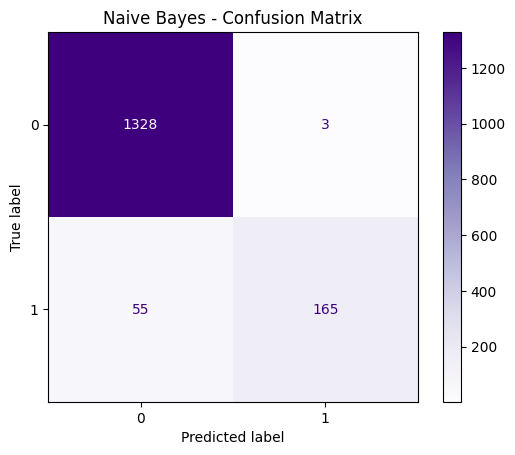


Logistic Regression - Model Evaluation:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1331
           1       0.97      0.72      0.83       220

    accuracy                           0.96      1551
   macro avg       0.96      0.86      0.90      1551
weighted avg       0.96      0.96      0.95      1551



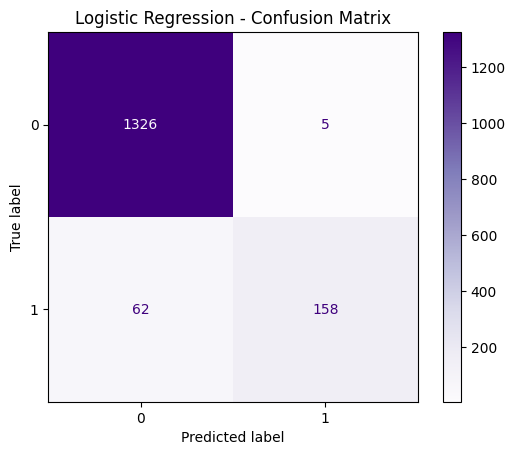


SVM - Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1331
           1       0.97      0.88      0.92       220

    accuracy                           0.98      1551
   macro avg       0.97      0.94      0.95      1551
weighted avg       0.98      0.98      0.98      1551



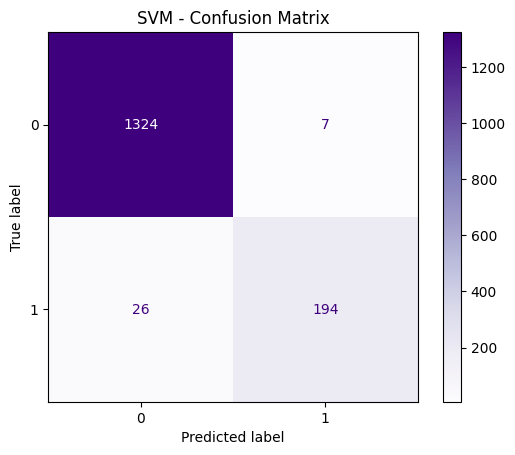


KNN - Model Evaluation:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1331
           1       1.00      0.39      0.56       220

    accuracy                           0.91      1551
   macro avg       0.95      0.69      0.75      1551
weighted avg       0.92      0.91      0.90      1551



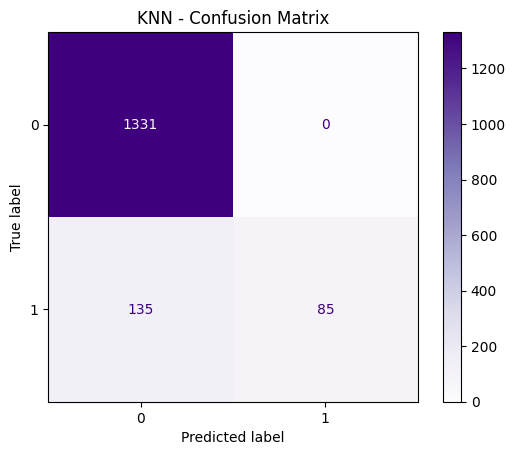


Decision Tree - Model Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1331
           1       0.85      0.80      0.83       220

    accuracy                           0.95      1551
   macro avg       0.91      0.89      0.90      1551
weighted avg       0.95      0.95      0.95      1551



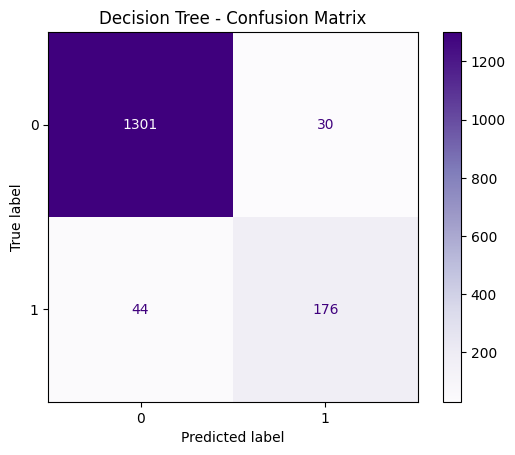


Random Forest - Model Evaluation:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1331
           1       0.99      0.78      0.87       220

    accuracy                           0.97      1551
   macro avg       0.98      0.89      0.93      1551
weighted avg       0.97      0.97      0.97      1551



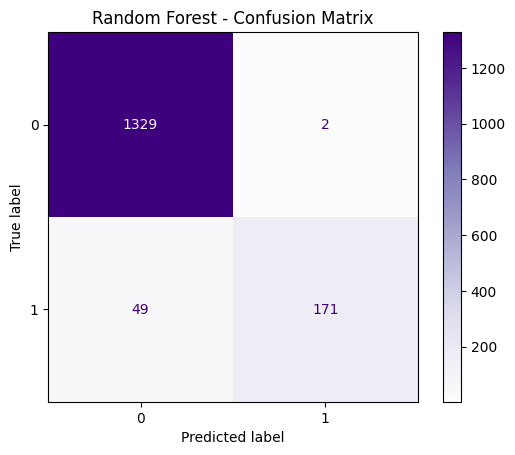


XGBoost - Model Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1331
           1       0.94      0.83      0.88       220

    accuracy                           0.97      1551
   macro avg       0.96      0.91      0.93      1551
weighted avg       0.97      0.97      0.97      1551



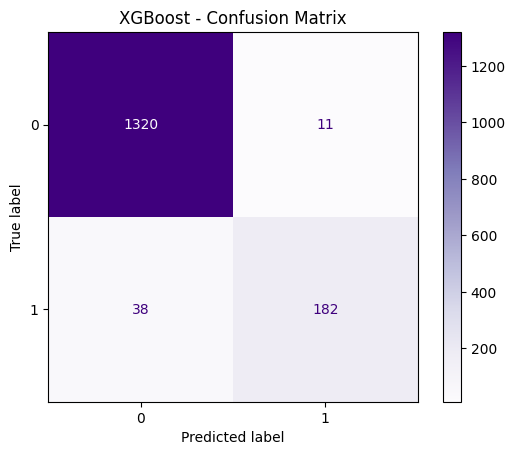

In [44]:
# Function to train, predict, and evaluate models
def evaluate_model(name, model):
    print(f"\n{name} - Model Evaluation:")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples', values_format='d')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()
    # Train and evaluate all models
for name, model in models.items():
    evaluate_model(name, model)

<div style="border-radius: 15px 0 15px 0px; border: 2px solid #f1c40f; padding: 10px; background-color: #6F4C5B; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #f1c40f; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 24px;">🚀 If you found this notebook helpful, please consider giving it an upvote! 👍</h1>
    <p style="color: #ecf0f1; font-size: 18px; text-align: center;">Your support motivates me to create more useful content like this, and it helps others discover the notebook too! 🙌</p>
    <p style="color: #ecf0f1; font-size: 18px; text-align: center;">Thank you for your time, and I hope this notebook brings value to your data science journey! 💡😊</p>
</div>